In [2]:
# Install the required libraries
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
!pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip install patchify

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-pyh1kvm9
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-pyh1kvm9
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=5f86493e69a61a51ed63faf718bfda76eef358d72f6fe0a48b13ad0a136d0632
  Stored in directory: /tmp/pip-ephem-wheel-cache-ncctuqh9/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/11

In [1]:
from datasets import load_dataset
dataset = load_dataset("back2classroom/sidewalks", split='train')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


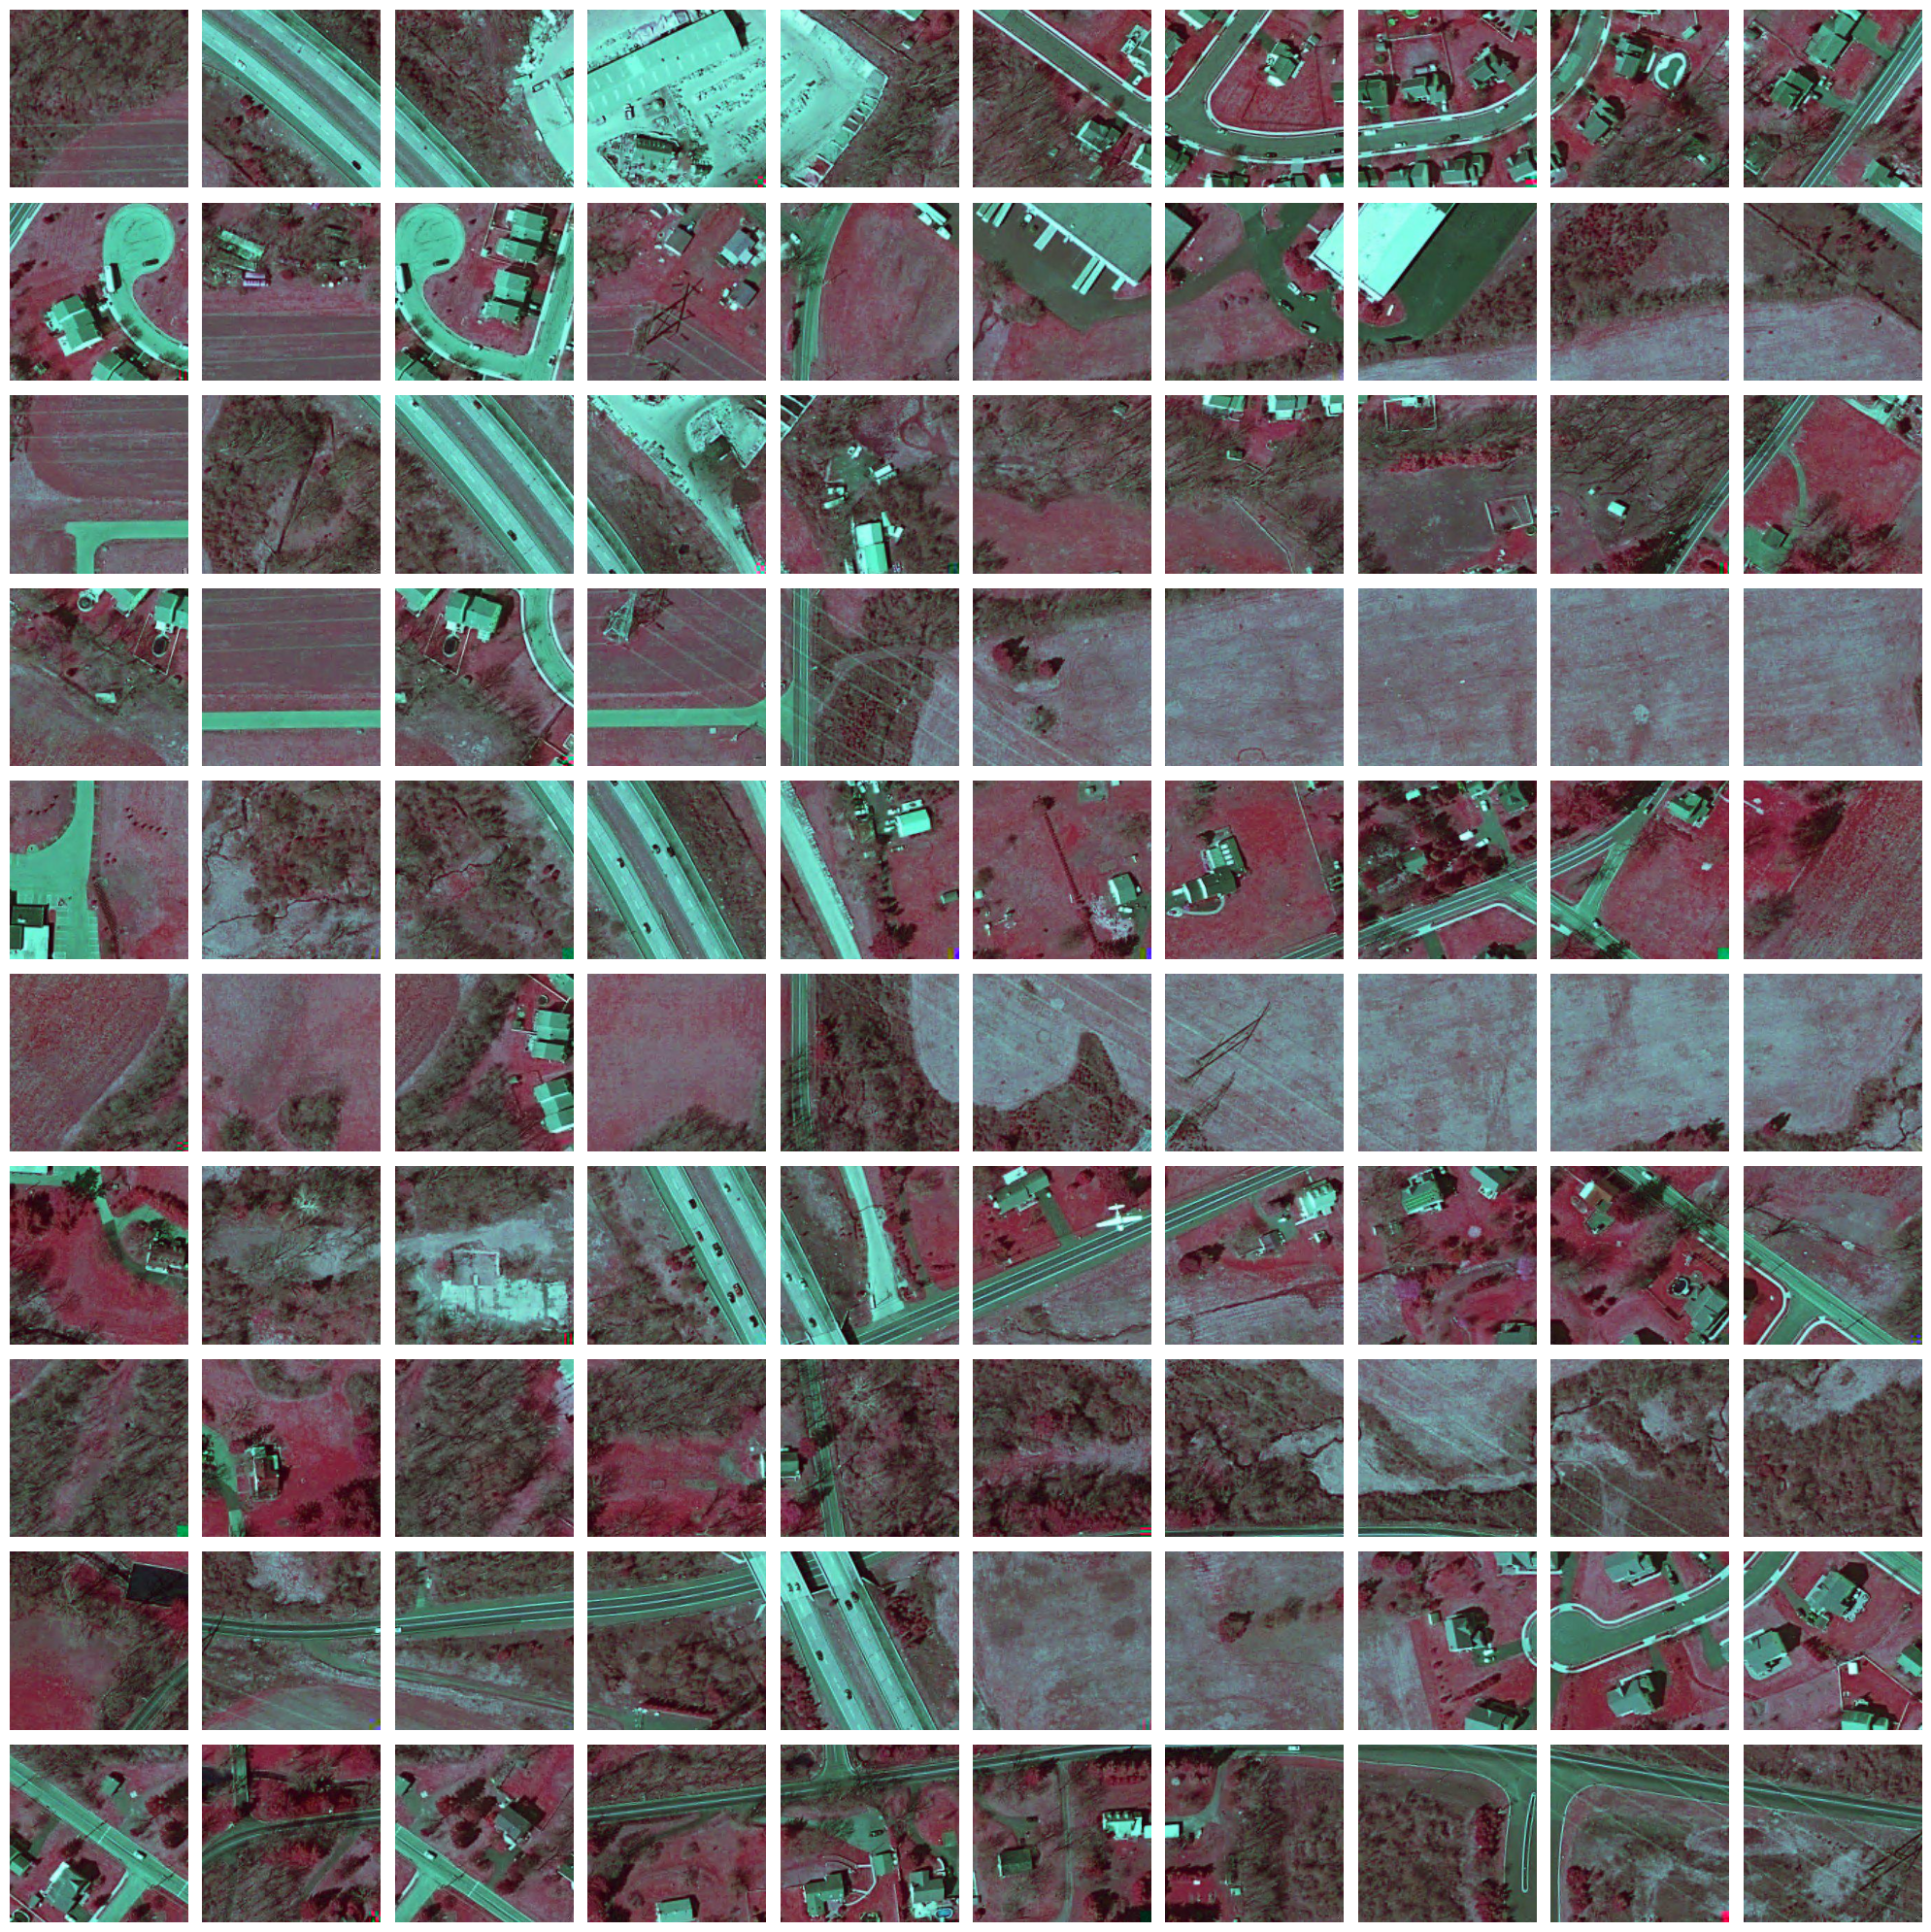

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import io
from PIL import Image

fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(20, 20))

axes = axes.flatten()

for i in range(100):
    example = dataset[i]['tif']
    with io.BytesIO(example) as buff:
        image = Image.open(buff)
        im_arr = np.array(image)

    axes[i].imshow(im_arr)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


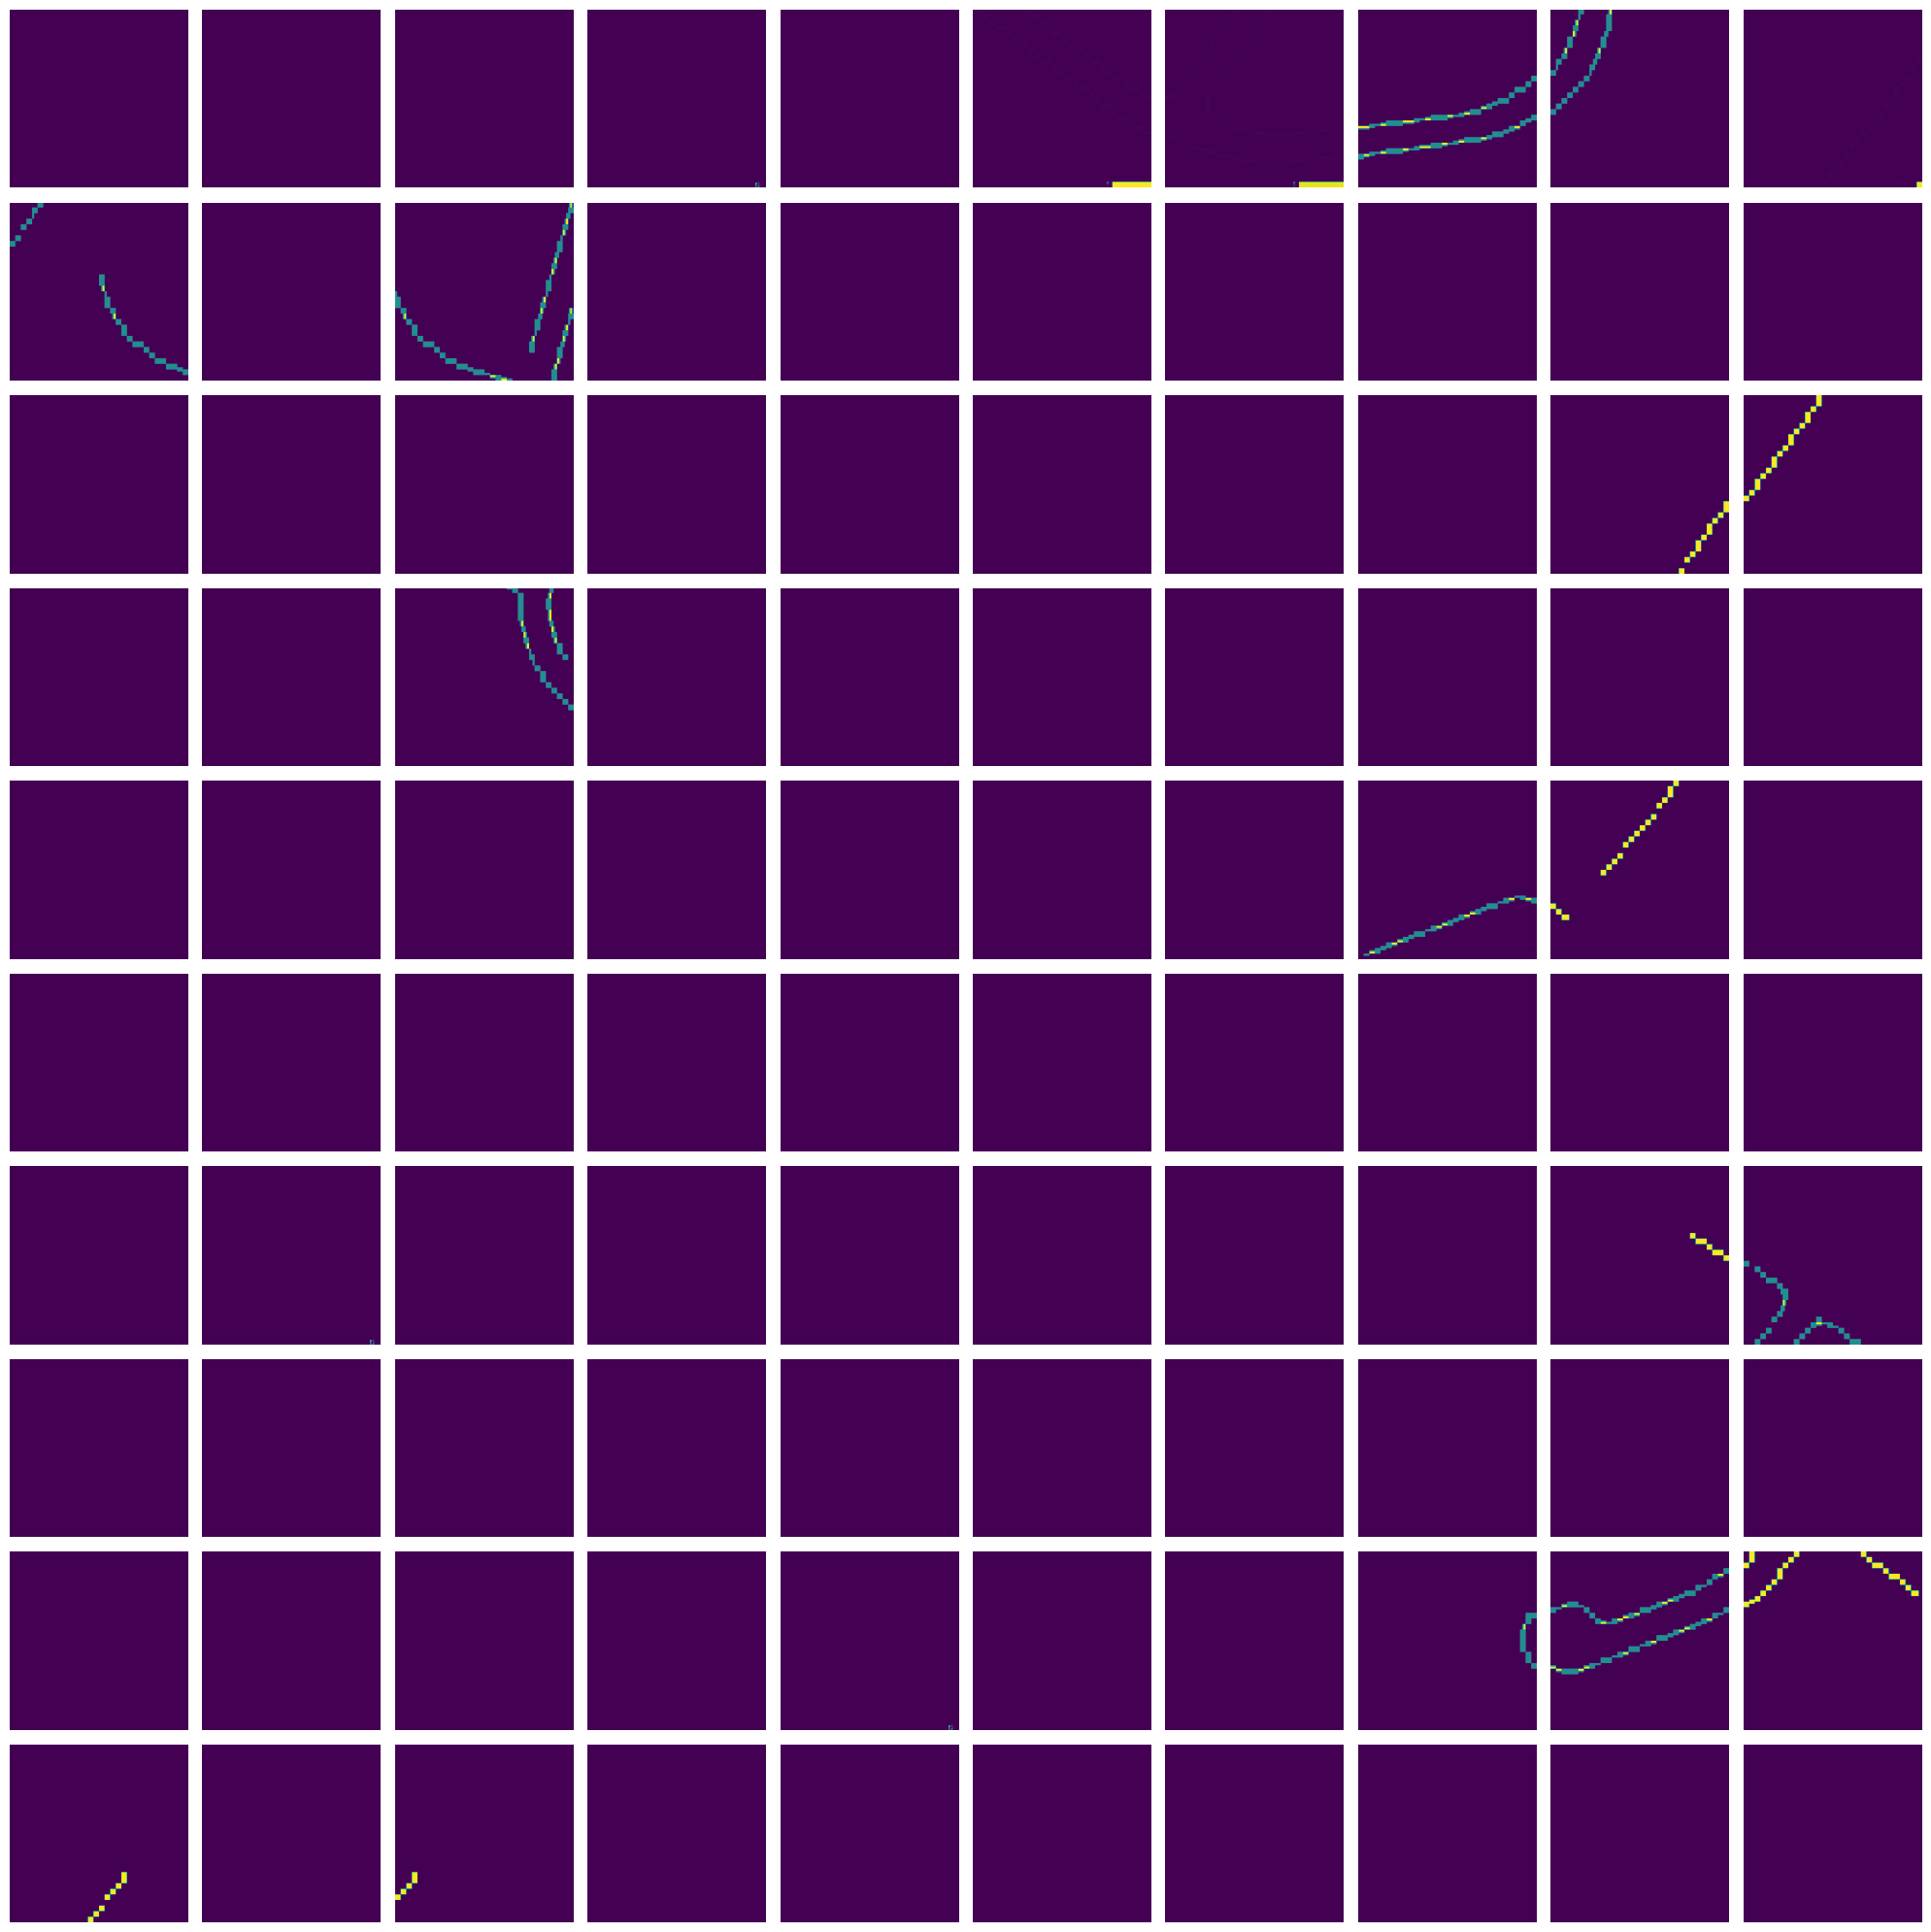

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import io
from PIL import Image

fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(20, 20))

axes = axes.flatten()

for i in range(100):
    example = dataset[i]['label_tif']
    with io.BytesIO(example) as buff:
        image = Image.open(buff)
        im_arr = np.array(image)

    axes[i].imshow(im_arr)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


The code snippet processes a dataset of 30,000 images, loading and transforming each image and its corresponding mask from binary data into a format for our dataset used for training.



The script was adapted to process only 30,000 images because running the full dataset was causing system crashes due to the limited memory capacity of the T4 GPU we used. Initially, attempts to use the entire dataset led to overwhelming the GPU and JupyterHub's RAM, prompting frequent crashes. To work around this, we filtered out images with empty masks and processed a manageable subset, ensuring we used only meaningful data. This approach helped stabilize the system and allowed us to complete the training effectively.



In [2]:
import numpy as np
import io
from PIL import Image

image_dataset = []
mask_dataset = []

target_size = (256, 256)

for i in range(30000):
    image_data = dataset[i]['tif']
    mask_data = dataset[i]['label_tif']

    with io.BytesIO(image_data) as image_buff, io.BytesIO(mask_data) as mask_buff:
        # Open and resize the image
        image = Image.open(image_buff)
        image = image.resize(target_size).convert('RGB')  # Convert to RGB if not already

        # Convert the image to numpy array
        image_array = np.array(image)

        mask = Image.open(mask_buff)
        mask = mask.resize(target_size).convert('RGB')  # Convert to RGB if not already
        mask = mask.convert('L')  # Convert to grayscale
        mask_array = np.array(mask)

        # Append to datasets if not empty
        if np.any(image_array) and np.any(mask_array):
            image_dataset.append(image_array)
            mask_dataset.append(mask_array)

print(f"Filtered image dataset size: {len(image_dataset)}")
print(f"Filtered mask dataset size: {len(mask_dataset)}")


Filtered image dataset size: 14149
Filtered mask dataset size: 14149


In [3]:
import numpy as np

def split_dataset(data, n_splits):
    # Split the dataset into n_splits parts
    split_size = len(data) // n_splits
    remainder = len(data) % n_splits
    datasets = []
    start = 0
    for i in range(n_splits):
        end = start + split_size + (1 if i < remainder else 0)
        datasets.append(data[start:end])
        start = end
    return datasets

# Assuming image_dataset and mask_dataset are already filled
n_splits = 5
image_datasets = split_dataset(image_dataset, n_splits)
mask_datasets = split_dataset(mask_dataset, n_splits)

# Assign to variables
image1_dataset, image2_dataset, image3_dataset, image4_dataset, image5_dataset = image_datasets
mask1_dataset, mask2_dataset, mask3_dataset, mask4_dataset, mask5_dataset = mask_datasets

# Display the size of each dataset to verify
for i, (img_data, msk_data) in enumerate(zip(image_datasets, mask_datasets), start=1):
    print(f"Image{i}_dataset size: {len(img_data)}, Mask{i}_dataset size: {len(msk_data)}")


Image1_dataset size: 2830, Mask1_dataset size: 2830
Image2_dataset size: 2830, Mask2_dataset size: 2830
Image3_dataset size: 2830, Mask3_dataset size: 2830
Image4_dataset size: 2830, Mask4_dataset size: 2830
Image5_dataset size: 2829, Mask5_dataset size: 2829


In [4]:
images1 =np.array(image1_dataset)
# images2 =np.array(image2_dataset)
# images3 =np.array(image3_dataset)
# images4 =np.array(imag4_dataset)
# images5 =np.array(image5_dataset)

In [5]:
mask1 = np.array(mask1_dataset)
# mask2 = np.array(mask2_dataset)
# mask3 = np.array(mask3_dataset)
# mask4 = np.array(mask4_dataset)
# mask5 = np.array(mask5_dataset)

In [6]:
from datasets import Dataset
from PIL import Image
# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in images1],
    "label": [Image.fromarray(mask) for mask in mask1],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

In [7]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 2830
})

In [8]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  if ground_truth_map.ndim != 2:
        raise ValueError("Input must be a 2D array")
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [9]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [10]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [11]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [12]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

In [13]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [14]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [16]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 1

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

100%|██████████| 1415/1415 [23:41<00:00,  1.00s/it]

EPOCH: 0
Mean loss: -130.76052778779197


In [17]:
# Save the model's state dictionary to a file

torch.save(model.state_dict(), "/content/model_state.pt")

In [18]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [19]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_mito_model.load_state_dict(torch.load("/content/model_state.pt"))

<All keys matched successfully>

In [20]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

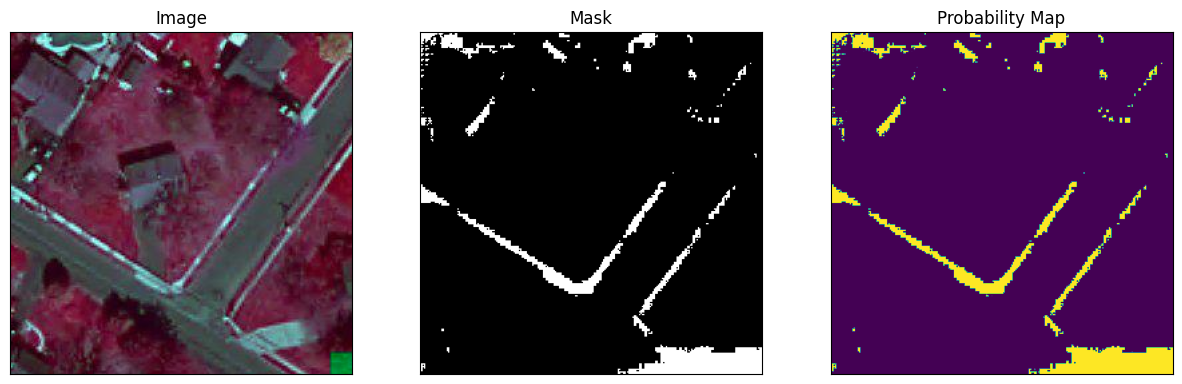

In [24]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

# let's take a random training example
idx = random.randint(0, images1.shape[0]-1)

# load image
test_image = dataset[idx]["image"]

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()
